In [8]:
%pip install -r ../../requirements.txt

  Using cached BindsNET-0.2.9-py3-none-any.whl
  Using cached gym-0.18.0-py3-none-any.whl


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.14/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import argparse

import cv2
import torch
import torch.nn
import numpy as np
import random
import gym
from collections import namedtuple
import matplotlib.pyplot as plt
from typing import List, Tuple
from collections import deque
from statistics import mean

In [10]:
Args = namedtuple('Args', ['gamma', 'env', 'n_episode', 'batch_size', 'hidden_dim', 'capacity', 'max_episode', 'min_eps'])
FLAGS = Args(gamma=0.99, env='BreakoutDeterministic-v4', n_episode=1000, batch_size=32, hidden_dim=12, capacity=50000, max_episode=1000, min_eps=0.01)

In [11]:
Transition = namedtuple("Transition", field_names=["state", "action", "reward", "next_state", "done"])

In [12]:
class ReplayMemory(object):

    def __init__(self, capacity: int) -> None:
        """Replay memory class
        """
        self.capacity = capacity
        self.cursor = 0
        self.memory = []

    def push(self,
             state: np.ndarray,
             action: int,
             reward: int,
             next_state: np.ndarray,
             done: bool) -> None:
        """Creates `Transition` and insert
        """
        if len(self) < self.capacity:
            self.memory.append(None)

        self.memory[self.cursor] = Transition(state,
                                              action, reward, next_state, done)
        self.cursor = (self.cursor + 1) % self.capacity

    def pop(self, batch_size: int) -> List[Transition]:
        """Returns a randomly sampled minibatch
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Returns the length """
        return len(self.memory)

In [13]:
class DQN(torch.nn.Module):
    def __init__(self, input_shape: [int], output_dim: int, hidden_dim: int, batch_size: int) -> None:
        """DQN Network
        """
        super(DQN, self).__init__()
        w, h, c = input_shape
        kernel_size = 3
        padding = 1
        stride = 1
        out_channels = 3

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(19200, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25)
        )

        self.final = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns a Q_value
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.final(x)

        return x

In [14]:
class Agent(object):

    def __init__(self, input_shape: [int], output_dim: int, hidden_dim: int, batch_size: int) -> None:
        """Agent class
        """
        self.dqn = DQN(input_shape, output_dim, hidden_dim, batch_size)
        self.input_dim = input_shape
        self.output_dim = output_dim

        self.loss_fn = torch.nn.MSELoss()
        self.optim = torch.optim.Adam(self.dqn.parameters())

    def _to_variable(self, x: np.ndarray) -> torch.Tensor:
        """torch.Variable syntax helper
        """
        return torch.autograd.Variable(torch.Tensor(x))

    def get_action(self, states: np.ndarray, eps: float) -> int:
        """Returns an action
        """
        if np.random.rand() < eps:
            return np.random.choice(self.output_dim)
        else:
            self.dqn.train(mode=False)
            scores = self.get_Q(np.array([states]))
            _, argmax = torch.max(scores.data, 1)
            return int(argmax.numpy())

    def get_Q(self, states: np.ndarray) -> torch.FloatTensor:
        """Returns `Q-value`
        """
        states = self._to_variable(states)
        self.dqn.train(mode=False)

        return self.dqn(states)

    def train(self, Q_pred: torch.FloatTensor, Q_true: torch.FloatTensor) -> float:
        """Computes `loss` and backpropagation
        """
        self.dqn.train(mode=True)
        self.optim.zero_grad()
        loss = self.loss_fn(Q_pred, Q_true)
        loss.backward()
        self.optim.step()
        return loss

In [15]:
def preprocess(states: np.ndarray):
    """Preprocesses gym state
    """
    # Crop
    states = states[34:194, 0:160, :]

    # Convert to grayscale
    states = cv2.cvtColor(states, cv2.COLOR_RGB2GRAY)

    # Subsample to 80x80
    states = cv2.resize(states, (80, 80))
    states = cv2.threshold(states, 0, 1, cv2.THRESH_BINARY)[1]

    states = states.reshape(1, states.shape[0], states.shape[1])
    return states

In [16]:
def train_helper(agent: Agent, minibatch: List[Transition], gamma: float) -> float:
    """ Train on minibatch data
    """
    states = np.array([x.state for x in minibatch])
    actions = np.array([x.action for x in minibatch])
    rewards = np.array([x.reward for x in minibatch])
    next_states = np.array([x.next_state for x in minibatch])
    Q_predict = agent.get_Q(states)
    Q_target = Q_predict.clone().data.numpy()
    Q_target[np.arange(len(Q_target)), actions] = rewards + gamma * np.max(agent.get_Q(next_states).data.numpy(),
                                                                           axis=1)
    Q_target = agent._to_variable(Q_target)

    return agent.train(Q_predict, Q_target)

In [17]:
def play_episode(env: gym.Env,
                 agent: Agent,
                 replay_memory: ReplayMemory,
                 eps: float,
                 batch_size: int) -> int:
    """Play an episode
    """
    s = env.reset()
    s = preprocess(s)
    done = False
    total_reward = 0

    while not done:
        a = agent.get_action(s, eps)
        s2, r, done, info = env.step(a)
        env.render()

        # Preprocessing step
        s2 = preprocess(s2)
        r = clip_reward(r)

        total_reward += r

        if done:
            r = -1
        replay_memory.push(s, a, r, s2, done)

        if len(replay_memory) > batch_size:
            minibatch = replay_memory.pop(batch_size)
            train_helper(agent, minibatch, FLAGS.gamma)

        s = s2

    return total_reward

In [18]:
def get_env_dim(env: gym.Env) -> Tuple[int, int]:
    """Returns input_dim & output_dim
    """
    input_dim = env.observation_space.shape
    output_dim = env.action_space.n

    return input_dim, output_dim

In [19]:
def epsilon_annealing(epsiode: int, max_episode: int, min_eps: float) -> float:
    """Returns 𝜺 for 𝜺-annealing
    1.0---|\
          | \
          |  \
    min_e +---+------->
              |
              max_episode
    """

    slope = (min_eps - 1.0) / max_episode
    return max(slope * epsiode + 1.0, min_eps)

In [20]:
def clip_reward(reward):
    """Clip reward so that it's in [-1, 1]
    """
    if reward < -1:
        reward = -1
    elif reward > 1:
        reward = 1
    return reward

[Episode:     1] Reward:   1.0 𝜺-greedy:  1.00
[Episode:     2] Reward:   1.0 𝜺-greedy:  1.00
[Episode:     3] Reward:   3.0 𝜺-greedy:  1.00
[Episode:     4] Reward:   0.0 𝜺-greedy:  1.00
[Episode:     5] Reward:   2.0 𝜺-greedy:  1.00
[Episode:     6] Reward:   0.0 𝜺-greedy:  1.00
[Episode:     7] Reward:   0.0 𝜺-greedy:  0.99
[Episode:     8] Reward:   0.0 𝜺-greedy:  0.99
[Episode:     9] Reward:   0.0 𝜺-greedy:  0.99
[Episode:    10] Reward:   2.0 𝜺-greedy:  0.99
[Episode:    11] Reward:   1.0 𝜺-greedy:  0.99
[Episode:    12] Reward:   1.0 𝜺-greedy:  0.99
[Episode:    13] Reward:   1.0 𝜺-greedy:  0.99
[Episode:    14] Reward:   0.0 𝜺-greedy:  0.99
[Episode:    15] Reward:   1.0 𝜺-greedy:  0.99
[Episode:    16] Reward:   0.0 𝜺-greedy:  0.99
[Episode:    17] Reward:   0.0 𝜺-greedy:  0.98
[Episode:    18] Reward:   1.0 𝜺-greedy:  0.98
[Episode:    19] Reward:   0.0 𝜺-greedy:  0.98
[Episode:    20] Reward:   2.0 𝜺-greedy:  0.98
[Episode:    21] Reward:   2.0 𝜺-greedy:  0.98
[Episode:    

[Episode:   172] Reward:   1.0 𝜺-greedy:  0.83
[Episode:   173] Reward:   1.0 𝜺-greedy:  0.83
[Episode:   174] Reward:   1.0 𝜺-greedy:  0.83
[Episode:   175] Reward:   1.0 𝜺-greedy:  0.83
[Episode:   176] Reward:   1.0 𝜺-greedy:  0.83
[Episode:   177] Reward:   1.0 𝜺-greedy:  0.83
[Episode:   178] Reward:   1.0 𝜺-greedy:  0.82
[Episode:   179] Reward:   0.0 𝜺-greedy:  0.82
[Episode:   180] Reward:   0.0 𝜺-greedy:  0.82
[Episode:   181] Reward:   0.0 𝜺-greedy:  0.82
[Episode:   182] Reward:   2.0 𝜺-greedy:  0.82
[Episode:   183] Reward:   1.0 𝜺-greedy:  0.82
[Episode:   184] Reward:   2.0 𝜺-greedy:  0.82
[Episode:   185] Reward:   0.0 𝜺-greedy:  0.82
[Episode:   186] Reward:   1.0 𝜺-greedy:  0.82
[Episode:   187] Reward:   1.0 𝜺-greedy:  0.82
[Episode:   188] Reward:   2.0 𝜺-greedy:  0.81
[Episode:   189] Reward:   1.0 𝜺-greedy:  0.81
[Episode:   190] Reward:   0.0 𝜺-greedy:  0.81
[Episode:   191] Reward:   0.0 𝜺-greedy:  0.81
[Episode:   192] Reward:   1.0 𝜺-greedy:  0.81
[Episode:   1

[Episode:   343] Reward:   1.0 𝜺-greedy:  0.66
[Episode:   344] Reward:   1.0 𝜺-greedy:  0.66
[Episode:   345] Reward:   2.0 𝜺-greedy:  0.66
[Episode:   346] Reward:   1.0 𝜺-greedy:  0.66
[Episode:   347] Reward:   0.0 𝜺-greedy:  0.66
[Episode:   348] Reward:   0.0 𝜺-greedy:  0.66
[Episode:   349] Reward:   1.0 𝜺-greedy:  0.66
[Episode:   350] Reward:   2.0 𝜺-greedy:  0.65
[Episode:   351] Reward:   3.0 𝜺-greedy:  0.65
[Episode:   352] Reward:   1.0 𝜺-greedy:  0.65
[Episode:   353] Reward:   1.0 𝜺-greedy:  0.65
[Episode:   354] Reward:   1.0 𝜺-greedy:  0.65
[Episode:   355] Reward:   0.0 𝜺-greedy:  0.65
[Episode:   356] Reward:   1.0 𝜺-greedy:  0.65
[Episode:   357] Reward:   2.0 𝜺-greedy:  0.65
[Episode:   358] Reward:   0.0 𝜺-greedy:  0.65
[Episode:   359] Reward:   4.0 𝜺-greedy:  0.65
[Episode:   360] Reward:   3.0 𝜺-greedy:  0.64
[Episode:   361] Reward:   6.0 𝜺-greedy:  0.64
[Episode:   362] Reward:   1.0 𝜺-greedy:  0.64
[Episode:   363] Reward:   1.0 𝜺-greedy:  0.64
[Episode:   3

[Episode:   514] Reward:   3.0 𝜺-greedy:  0.49
[Episode:   515] Reward:   1.0 𝜺-greedy:  0.49
[Episode:   516] Reward:   2.0 𝜺-greedy:  0.49
[Episode:   517] Reward:   4.0 𝜺-greedy:  0.49
[Episode:   518] Reward:   0.0 𝜺-greedy:  0.49
[Episode:   519] Reward:   1.0 𝜺-greedy:  0.49
[Episode:   520] Reward:   0.0 𝜺-greedy:  0.49
[Episode:   521] Reward:   0.0 𝜺-greedy:  0.49
[Episode:   522] Reward:   7.0 𝜺-greedy:  0.48
[Episode:   523] Reward:   1.0 𝜺-greedy:  0.48
[Episode:   524] Reward:   1.0 𝜺-greedy:  0.48
[Episode:   525] Reward:   2.0 𝜺-greedy:  0.48
[Episode:   526] Reward:   3.0 𝜺-greedy:  0.48
[Episode:   527] Reward:   2.0 𝜺-greedy:  0.48
[Episode:   528] Reward:   1.0 𝜺-greedy:  0.48
[Episode:   529] Reward:   2.0 𝜺-greedy:  0.48
[Episode:   530] Reward:   3.0 𝜺-greedy:  0.48
[Episode:   531] Reward:   2.0 𝜺-greedy:  0.48
[Episode:   532] Reward:   0.0 𝜺-greedy:  0.47
[Episode:   533] Reward:   2.0 𝜺-greedy:  0.47
[Episode:   534] Reward:   1.0 𝜺-greedy:  0.47
[Episode:   5

[Episode:   685] Reward:   1.0 𝜺-greedy:  0.32
[Episode:   686] Reward:   3.0 𝜺-greedy:  0.32
[Episode:   687] Reward:   2.0 𝜺-greedy:  0.32
[Episode:   688] Reward:   2.0 𝜺-greedy:  0.32
[Episode:   689] Reward:   2.0 𝜺-greedy:  0.32
[Episode:   690] Reward:   2.0 𝜺-greedy:  0.32
[Episode:   691] Reward:   6.0 𝜺-greedy:  0.32
[Episode:   692] Reward:   3.0 𝜺-greedy:  0.32
[Episode:   693] Reward:   4.0 𝜺-greedy:  0.31
[Episode:   694] Reward:   4.0 𝜺-greedy:  0.31
[Episode:   695] Reward:   1.0 𝜺-greedy:  0.31
[Episode:   696] Reward:   5.0 𝜺-greedy:  0.31
[Episode:   697] Reward:   2.0 𝜺-greedy:  0.31
[Episode:   698] Reward:   2.0 𝜺-greedy:  0.31
[Episode:   699] Reward:   3.0 𝜺-greedy:  0.31
[Episode:   700] Reward:   2.0 𝜺-greedy:  0.31
[Episode:   701] Reward:   3.0 𝜺-greedy:  0.31
[Episode:   702] Reward:   4.0 𝜺-greedy:  0.31
[Episode:   703] Reward:   2.0 𝜺-greedy:  0.31
[Episode:   704] Reward:   4.0 𝜺-greedy:  0.30
[Episode:   705] Reward:   5.0 𝜺-greedy:  0.30
[Episode:   7

[Episode:   856] Reward:   2.0 𝜺-greedy:  0.15
[Episode:   857] Reward:   4.0 𝜺-greedy:  0.15
[Episode:   858] Reward:   3.0 𝜺-greedy:  0.15
[Episode:   859] Reward:   4.0 𝜺-greedy:  0.15
[Episode:   860] Reward:   4.0 𝜺-greedy:  0.15
[Episode:   861] Reward:   2.0 𝜺-greedy:  0.15
[Episode:   862] Reward:   2.0 𝜺-greedy:  0.15
[Episode:   863] Reward:   2.0 𝜺-greedy:  0.15
[Episode:   864] Reward:   3.0 𝜺-greedy:  0.15
[Episode:   865] Reward:   2.0 𝜺-greedy:  0.14
[Episode:   866] Reward:   4.0 𝜺-greedy:  0.14
[Episode:   867] Reward:   1.0 𝜺-greedy:  0.14
[Episode:   868] Reward:   1.0 𝜺-greedy:  0.14
[Episode:   869] Reward:   3.0 𝜺-greedy:  0.14
[Episode:   870] Reward:   1.0 𝜺-greedy:  0.14
[Episode:   871] Reward:   5.0 𝜺-greedy:  0.14
[Episode:   872] Reward:   2.0 𝜺-greedy:  0.14
[Episode:   873] Reward:   3.0 𝜺-greedy:  0.14
[Episode:   874] Reward:   4.0 𝜺-greedy:  0.14
[Episode:   875] Reward:   3.0 𝜺-greedy:  0.13
[Episode:   876] Reward:   2.0 𝜺-greedy:  0.13
[Episode:   8

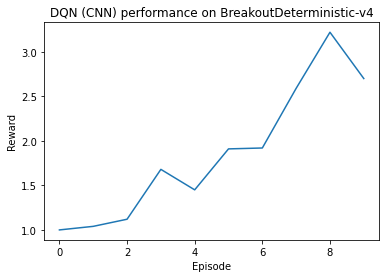

In [21]:
try:
    env = gym.make(FLAGS.env)
    env = gym.wrappers.Monitor(env, directory="monitors", force=True)

    average_rewards = []
    q = deque(maxlen=100)

    input_dim, output_dim = get_env_dim(env)

    agent = Agent((80, 80, 1) , output_dim, FLAGS.hidden_dim, FLAGS.batch_size)
    replay_memory = ReplayMemory(FLAGS.capacity)

    for i in range(FLAGS.n_episode):
        eps = epsilon_annealing(i, FLAGS.max_episode, FLAGS.min_eps)
        r = play_episode(env, agent, replay_memory, eps, FLAGS.batch_size)
        print("[Episode: {:5}] Reward: {:5} 𝜺-greedy: {:5.2f}".format(i + 1, r, eps))

        q.append(r)
        if i % 100 == 0:
            average_rewards.append(mean(q))

    name = "DQN-cnn-{}-{}-{}-reward_clamping".format(FLAGS.env, FLAGS.n_episode, FLAGS.gamma)

    fig, ax = plt.subplots()
    ax.plot(average_rewards)

    ax.set(xlabel='Episode', ylabel='Reward',
           title='DQN (CNN) performance on {}'.format(FLAGS.env))
    plt.show()

finally:
    env.close()